In [ ]:
# ====================
# Credit Card Fraud Detection using Deep Learning
# Author: Alexandros Polyzoidis
# ====================
# This project uses a deep learning neural network in PyTorch to detect fraudulent 
# credit card transactions. We aim to build a robust binary classifier that 
# handles the class imbalance and optimizes model performance for this important problem.

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\apoly\OneDrive\Documents\GitHub\credit_card.csv\creditcard.csv')

# Basic data exploration
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# ====================
# Data Preprocessing
# ====================
# Selecting features and target variables
features_numpy = df.iloc[:, 1:29]  # Features: V1 to V28
targets_numpy = df['Class'].values  # Target: Class (Fraud or Non-fraud)

# Normalizing the features (excluding the target)
scaler = StandardScaler()
features_numpy = scaler.fit_transform(features_numpy)

# Convert target values to numpy array and integers
targets_numpy = np.array(targets_numpy).astype(int)

In [4]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
features_resampled, targets_resampled = smote.fit_resample(features_numpy, targets_numpy)

# Then split the resampled dataset into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features_resampled, targets_resampled, test_size=0.1, random_state=42
)

print('features_train shape:', features_train.shape)
print('targets_train shape:', targets_train.shape)

print('features_test shape:', features_test.shape)
print('targets_test shape:', targets_test.shape)

features_train shape: (511767, 28)
targets_train shape: (511767,)
features_test shape: (56863, 28)
targets_test shape: (56863,)


In [5]:
# ====================
# Convert to Torch Tensors
# ====================

# Convert to PyTorch tensors
featuresTrain = torch.tensor(features_train).float()
targetsTrain = torch.tensor(targets_train).long()
featuresTest = torch.tensor(features_test).float()
targetsTest = torch.tensor(targets_test).long()

# Create Datasets and DataLoaders
train_dataset = TensorDataset(featuresTrain, targetsTrain)
test_dataset = TensorDataset(featuresTest, targetsTest)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# ====================
# Neural Network Model Definition
# ====================
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28, 340)
        self.fc2 = nn.Linear(340, 220)
        self.fc3 = nn.Linear(220, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 2)  # Binary classification (fraud or non-fraud)
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim=1)
        return x
    
# Instantiate the model
model = Classifier()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# ====================
# Training the Model
# ====================
num_epochs = 40
train_accuracy = []
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    loss_values.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/40, Loss: 0.0155, Accuracy: 99.56%
Epoch 2/40, Loss: 0.0054, Accuracy: 99.89%
Epoch 3/40, Loss: 0.0042, Accuracy: 99.92%
Epoch 4/40, Loss: 0.0039, Accuracy: 99.93%
Epoch 5/40, Loss: 0.0033, Accuracy: 99.94%
Epoch 6/40, Loss: 0.0036, Accuracy: 99.94%
Epoch 7/40, Loss: 0.0033, Accuracy: 99.94%
Epoch 8/40, Loss: 0.0030, Accuracy: 99.95%
Epoch 9/40, Loss: 0.0029, Accuracy: 99.95%
Epoch 10/40, Loss: 0.0024, Accuracy: 99.96%
Epoch 11/40, Loss: 0.0035, Accuracy: 99.95%
Epoch 12/40, Loss: 0.0025, Accuracy: 99.96%
Epoch 13/40, Loss: 0.0030, Accuracy: 99.95%
Epoch 14/40, Loss: 0.0026, Accuracy: 99.96%
Epoch 15/40, Loss: 0.0030, Accuracy: 99.96%
Epoch 16/40, Loss: 0.0029, Accuracy: 99.96%
Epoch 17/40, Loss: 0.0024, Accuracy: 99.96%
Epoch 18/40, Loss: 0.0039, Accuracy: 99.96%
Epoch 19/40, Loss: 0.0027, Accuracy: 99.96%
Epoch 20/40, Loss: 0.0031, Accuracy: 99.96%
Epoch 21/40, Loss: 0.0038, Accuracy: 99.96%
Epoch 22/40, Loss: 0.0027, Accuracy: 99.97%
Epoch 23/40, Loss: 0.0027, Accuracy: 99.9

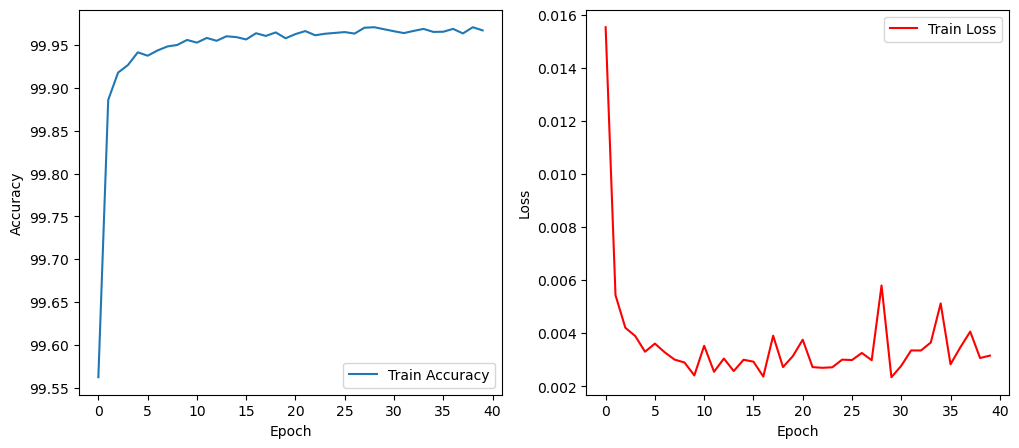

In [8]:
# ====================
# Plot Training Metrics
# ====================

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_values, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# ====================
# Evaluation on Test Set
# ====================
model.eval()
with torch.no_grad():
    test_outputs = model(featuresTest)
    _, test_predictions = torch.max(test_outputs, 1)

test_acc = (test_predictions == targetsTest).sum().item() / targetsTest.size(0) * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Print classification report
print(classification_report(targetsTest, test_predictions.numpy(), target_names=['Non-Fraud', 'Fraud']))

Test Accuracy: 99.97%
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     28499
       Fraud       1.00      1.00      1.00     28364

    accuracy                           1.00     56863
   macro avg       1.00      1.00      1.00     56863
weighted avg       1.00      1.00      1.00     56863



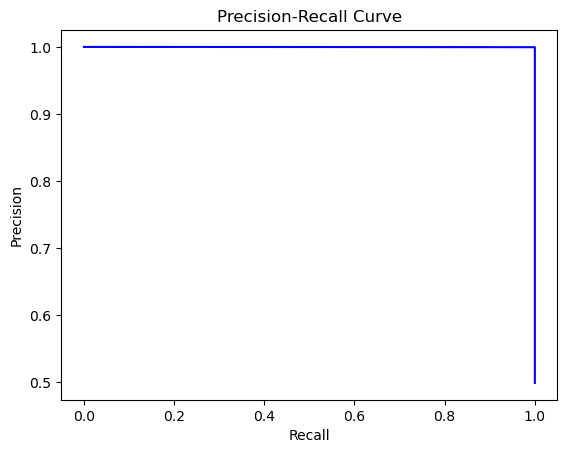

Average Precision Score: 1.00


In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get the predicted probabilities for the test set
probs = F.softmax(test_outputs, dim=1)[:, 1].numpy()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(targetsTest.numpy(), probs)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Average precision score
avg_precision = average_precision_score(targetsTest.numpy(), probs)
print(f"Average Precision Score: {avg_precision:.2f}")

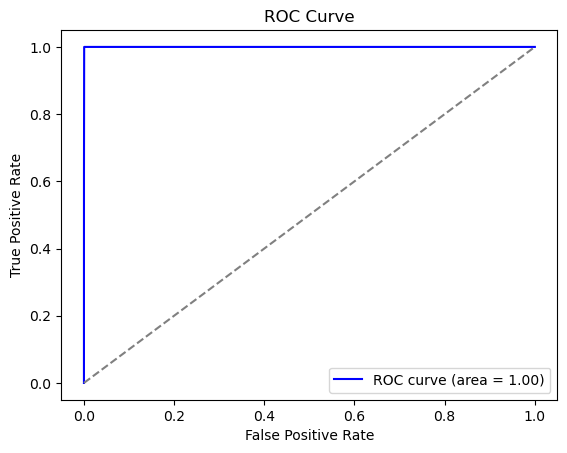

AUC-ROC: 1.00


In [11]:
# ====================
# ROC-AUC and Plot
# ====================
probabilities = F.softmax(test_outputs, dim=1)[:, 1].numpy()
roc_auc = roc_auc_score(targetsTest.numpy(), probabilities)
fpr, tpr, _ = roc_curve(targetsTest.numpy(), probabilities)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.2f}")

In [12]:
# Save the model
torch.save(model.state_dict(), 'fraud_detection_model.pth')

# Load the model
model = Classifier()
model.load_state_dict(torch.load('fraud_detection_model.pth'))
model.eval()

Classifier(
  (fc1): Linear(in_features=28, out_features=340, bias=True)
  (fc2): Linear(in_features=340, out_features=220, bias=True)
  (fc3): Linear(in_features=220, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)